In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, train_test_split, ShuffleSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
from itertools import product
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
import joblib  # 모델 저장을 위한 라이브러리

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


In [2]:
def calculate_metrics(y_true, y_pred, training_time):
	"""평가 지표 계산 함수"""
	return {
		'MAE': mean_absolute_error(y_true, y_pred),
		'MSE': mean_squared_error(y_true, y_pred),
		'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
		'R2': r2_score(y_true, y_pred),
		'RMSLE': np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred))),
		'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
		'Training_Time': training_time
	}

In [156]:
def classify_trend(arr):
    """ 상승(1), 동결(0), 하락(-1)으로 변환하는 함수 """
    trend = np.zeros_like(arr)
    trend[arr > 0] = 1   # 상승
    trend[arr < 0] = -1  # 하락
    return trend

### 광어

In [164]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
	"""
	LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.

	Args:
		data (pd.DataFrame): 학습 데이터셋.
		target_col (str): 예측 대상 열 이름.
		exclude_features (list): 학습에 제외할 피처 리스트.
		steps (int): 예측할 시점 개수.
		time_series (bool): 타임 시리즈 데이터 여부.

	Returns:
		model: 학습된 멀티아웃풋 모델.
	"""
	# 날짜 열을 datetime 형식으로 변환
	data['date'] = pd.to_datetime(data['date'])

	# 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
	for step in range(1, steps + 1):
		data[f'{target_col}+{step}'] = data[target_col].shift(-step)
	data = data.dropna()  # NaN 값 제거

	# 입력 데이터와 다중 출력 타겟 설정
	X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
	y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]

	# 특정 피처 제외 (exclude_features 리스트 기반)
	if exclude_features:
		X = X.drop(columns=exclude_features)
    
    # LightGBM 하이퍼파라미터 설정
	lgbm_params = {
		'n_estimators': 260,
		'max_depth': 8,
		'learning_rate': 0.1,
		'num_leaves': 9,
		'min_child_samples':  7,
		'subsample': 0.9,
		'colsample_bytree': 0.9,
		'random_state': 1030,
		'n_jobs': -1
	}

	# 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
	if time_series:
		test_size = len(X) // 10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		from sklearn.model_selection import ShuffleSplit
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	# MultiOutputRegressor로 멀티스텝 예측을 지원
	base_model = LGBMRegressor(**lgbm_params)
	multi_output_model = MultiOutputRegressor(base_model)

	# 모델 학습
	start_time = time.time()
	multi_output_model.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
	print("Feature names saved to 'feature_names_multi.pkl'")

	# 학습 시간 출력
	print(f"Training Time: {training_time:.2f} seconds")

	# 모델 예측
	y_pred = multi_output_model.predict(X)

	# 성능 평가 (RMSE, R2, MAE)
	rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
	r2 = r2_score(y, y_pred, multioutput='variance_weighted')
	mae = mean_absolute_error(y, y_pred, multioutput='raw_values')

	print("\n** Model Performance **")
	print(f"\nR2 Score: {r2:.4f}")
	print(f"\nRMSE (Per Step): {rmse}")
	print(f"\nMAE (Per Step): {mae}")

	avg_rmse = np.mean(rmse)
	max_rmse = np.max(rmse)
	min_rmse = np.min(rmse)
	avg_mae = np.mean(mae)

	print(f"\n평균 RMSE: {avg_rmse:.4f}")
	print(f"최대 RMSE: {max_rmse:.4f}")
	print(f"최소 RMSE: {min_rmse:.4f}")
	print(f'\n평균 MAE: {avg_mae:.4f}')
	print('-'*80)


	# 상승/하락 적중률 계산
	actual_trend = np.sign(y.diff(axis=1).fillna(0))
	predicted_trend = np.sign(y_pred[:, 1:] - y_pred[:, :-1])
	trend_accuracy = (actual_trend.iloc[:, 1:].values == predicted_trend).mean(axis=0) * 100

	avg_accuracy = np.mean(trend_accuracy)
	min_accuracy, max_accuracy = np.min(trend_accuracy), np.max(trend_accuracy)
	min_day, max_day = np.argmin(trend_accuracy) + 1, np.argmax(trend_accuracy) + 1

	print(f"\n평균 상승/하락 적중률: {avg_accuracy:.2f}%")
	print(f"최고 적중률: {max_accuracy:.2f}% (Day {max_day})")
	print(f"최저 적중률: {min_accuracy:.2f}% (Day {min_day})")

	print("일별 상승/하락 적중률:")
	for i, acc in enumerate(trend_accuracy, start=1):
		print(f"Day {i}: {acc:.2f}%")

	# 상승/하락 적중률 그래프
	plt.figure(figsize=(10, 5))
	plt.plot(range(1, steps ), trend_accuracy, marker='o', linestyle='-', label='적중률')
	plt.axhline(avg_accuracy, color='r', linestyle='--', label=f'평균 적중률: {avg_accuracy:.2f}%')
	plt.scatter(min_day , min_accuracy,  color='orange', s=50, label=f'최저점: Day {min_day} ({min_accuracy:.2f}%)', zorder= 3)
	plt.scatter(max_day , max_accuracy, color='red', s=50, label=f'최고점: Day {max_day} ({max_accuracy:.2f}%)', zorder= 3)
	plt.xlabel('예측 일 수')
	plt.ylabel('적중률 (%)')
	plt.title('광어 가격 상승/하락 적중률')
	plt.legend()
	plt.grid()
	plt.show()


	# 실제 데이터 트렌드 변환
	actual_trend = classify_trend(np.diff(y, axis=1))  # DataFrame에서 numpy로 변환

	predicted_up = np.ones_like(actual_trend)	# **쭉 상승(1) 예측**
	predicted_down = -np.ones_like(actual_trend)	# **쭉 하락(-1) 예측**
	predicted_flat = np.zeros_like(actual_trend)	# **쭉 동결(0) 예측**

	# 적중률 계산
	accuracy_up = (actual_trend == predicted_up).mean(axis=0) * 100
	accuracy_down = (actual_trend == predicted_down).mean(axis=0) * 100
	accuracy_flat = (actual_trend == predicted_flat).mean(axis=0) * 100

	# 평균 적중률 계산
	avg_accuracy_up = np.mean(accuracy_up)
	avg_accuracy_down = np.mean(accuracy_down)
	avg_accuracy_flat = np.mean(accuracy_flat)

	# 결과 출력
	print(f"\n** 무조건 상승 예측 시 평균 적중률: {avg_accuracy_up:.2f}% **")
	print(f"** 무조건 하락 예측 시 평균 적중률: {avg_accuracy_down:.2f}% **")
	print(f"** 무조건 동결 예측 시 평균 적중률: {avg_accuracy_flat:.2f}% **")



	# 중요도 시각화
	feature_importances = np.mean([
		model.feature_importances_ for model in multi_output_model.estimators_
	], axis=0)
	importance_df = pd.DataFrame({
		'Feature': X.columns,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)

	print("\nFeature Importances:")
	print(importance_df)

	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
	plt.tight_layout()
	plt.show()



	return multi_output_model




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5553
[LightGBM] [Info] Number of data points in the train set: 26233, number of used features: 32
[LightGBM] [Info] Start training from score 35911.720733
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5553
[LightGBM] [Info] Number of data points in the train set: 26233, number of used features: 32
[LightGBM] [Info] Start training from score 35912.028742
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5553
[LightGBM] [Info] Number of data points in the train set: 26233, number of used features: 32
[LightGBM] [Info] S

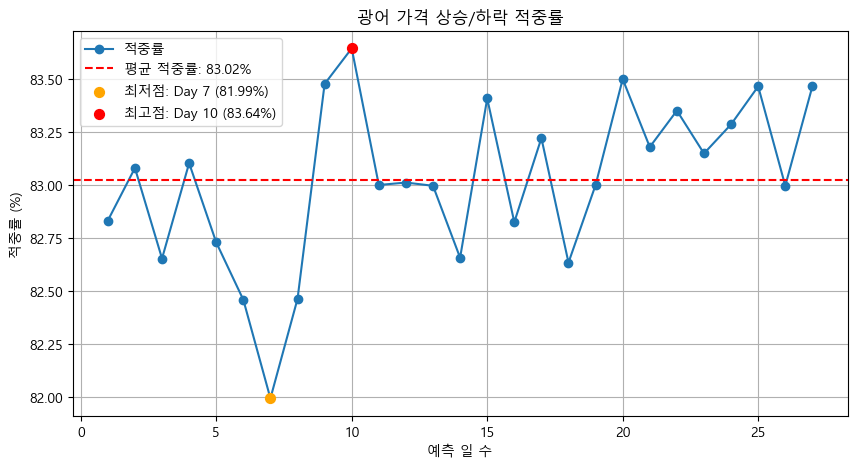


** 무조건 상승 예측 시 평균 적중률: 45.84% **
** 무조건 하락 예측 시 평균 적중률: 40.53% **
** 무조건 동결 예측 시 평균 적중률: 13.62% **

Feature Importances:
             Feature  Importance
10    avgPrice_lag_1  240.428571
21       광어_Gold_314  187.428571
25      광어_USD/KRW_1  181.571429
27          광어_WTI_1  150.107143
22      광어_KOSPI_136  140.821429
29    광어_수온_22107_79  102.178571
23        광어_MOVE_18   93.321429
24     광어_Silver_238   89.785714
26        광어_VIX_399   89.714286
5      m_부산민락어민활어직판장   72.678571
4         m_마포농수산물시장   68.071429
6        m_소래포구종합어시장   67.928571
0             m_가락시장   67.678571
1         m_강서농수산물시장   67.142857
3            m_노량진시장   65.214286
28    광어_기온_22105_97   58.714286
2         m_구리농수산물시장   52.500000
9      m_인천종합연안부두어시장   51.464286
8       m_안양평촌농수산물시장   50.535714
7         m_수원농수산물시장   48.642857
12        광어_20대_250   35.464286
11          광어_20대_1   16.250000
14        광어_30대_317   11.892857
15          광어_40대_1   10.892857
13          광어_30대_1   10.357143
16        광어_40대_330

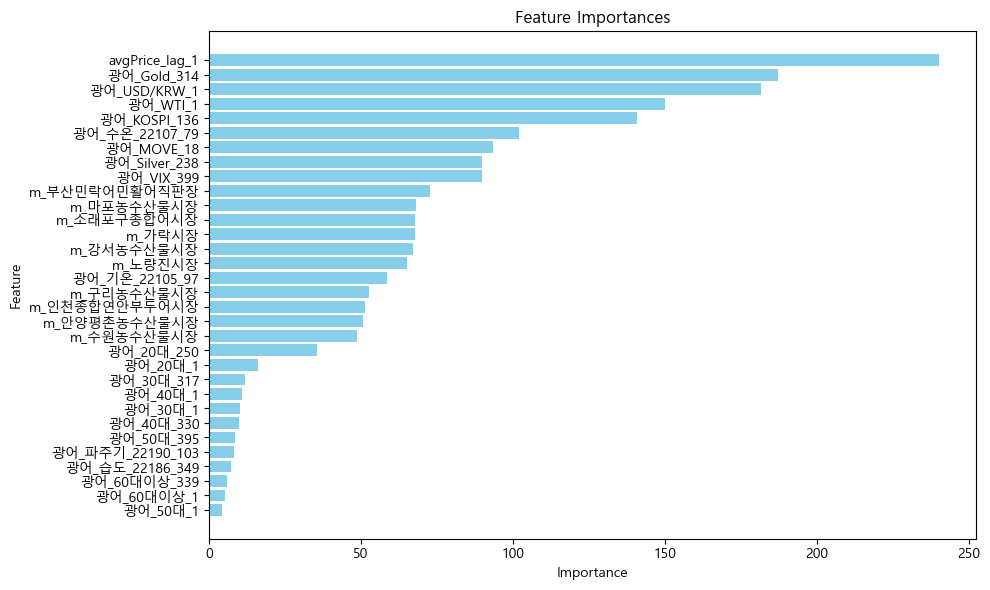

MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=0.9, max_depth=8,
                                             min_child_samples=7,
                                             n_estimators=260, n_jobs=-1,
                                             num_leaves=9, random_state=1030,
                                             subsample=0.9))

학습된 모델이 'lgbm_다중_광어.joblib'로 저장되었습니다.


In [165]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/광어_price_features_notnull.csv')
exclude_features = []
model_다중_광어 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_광어)

# 학습된 모델 저장
joblib.dump(model_다중_광어, 'lgbm_다중_광어.joblib')  

print("\n학습된 모델이 'lgbm_다중_광어.joblib'로 저장되었습니다.")

### 농어

In [166]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
	"""
	LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.

	Args:
		data (pd.DataFrame): 학습 데이터셋.
		target_col (str): 예측 대상 열 이름.
		exclude_features (list): 학습에 제외할 피처 리스트.
		steps (int): 예측할 시점 개수.
		time_series (bool): 타임 시리즈 데이터 여부.

	Returns:
		model: 학습된 멀티아웃풋 모델.
	"""
	# 날짜 열을 datetime 형식으로 변환
	data['date'] = pd.to_datetime(data['date'])

	# 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
	for step in range(1, steps + 1):
		data[f'{target_col}+{step}'] = data[target_col].shift(-step)
	data = data.dropna()  # NaN 값 제거

	# 입력 데이터와 다중 출력 타겟 설정
	X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
	y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]

	# 특정 피처 제외 (exclude_features 리스트 기반)
	if exclude_features:
		X = X.drop(columns=exclude_features)
    
    # LightGBM 하이퍼파라미터 설정
	lgbm_params = {
		'n_estimators': 100,
		'max_depth': 6,
		'learning_rate': 0.1,
		'num_leaves': 8,
		'min_child_samples': 6,
		'subsample': 0.9,
		'colsample_bytree': 0.9,
		'random_state': 1030,
		'n_jobs': -1
	}

	# 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
	if time_series:
		test_size = len(X) // 10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		from sklearn.model_selection import ShuffleSplit
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	# MultiOutputRegressor로 멀티스텝 예측을 지원
	base_model = LGBMRegressor(**lgbm_params)
	multi_output_model = MultiOutputRegressor(base_model)

	# 모델 학습
	start_time = time.time()
	multi_output_model.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
	print("Feature names saved to 'feature_names_multi.pkl'")

	# 학습 시간 출력
	print(f"Training Time: {training_time:.2f} seconds")

	# 모델 예측
	y_pred = multi_output_model.predict(X)

	# 성능 평가 (RMSE, R2, MAE)
	rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
	r2 = r2_score(y, y_pred, multioutput='variance_weighted')
	mae = mean_absolute_error(y, y_pred, multioutput='raw_values')

	print("\n** Model Performance **")
	print(f"\nR2 Score: {r2:.4f}")
	print(f"\nRMSE (Per Step): {rmse}")
	print(f"\nMAE (Per Step): {mae}")

	avg_rmse = np.mean(rmse)
	max_rmse = np.max(rmse)
	min_rmse = np.min(rmse)
	avg_mae = np.mean(mae)

	print(f"\n평균 RMSE: {avg_rmse:.4f}")
	print(f"최대 RMSE: {max_rmse:.4f}")
	print(f"최소 RMSE: {min_rmse:.4f}")
	print(f'\n평균 MAE: {avg_mae:.4f}')
	print('-'*80)


	# 상승/하락 적중률 계산
	actual_trend = np.sign(y.diff(axis=1).fillna(0))
	predicted_trend = np.sign(y_pred[:, 1:] - y_pred[:, :-1])
	trend_accuracy = (actual_trend.iloc[:, 1:].values == predicted_trend).mean(axis=0) * 100

	avg_accuracy = np.mean(trend_accuracy)
	min_accuracy, max_accuracy = np.min(trend_accuracy), np.max(trend_accuracy)
	min_day, max_day = np.argmin(trend_accuracy) + 1, np.argmax(trend_accuracy) + 1

	print(f"\n평균 상승/하락 적중률: {avg_accuracy:.2f}%")
	print(f"최고 적중률: {max_accuracy:.2f}% (Day {max_day})")
	print(f"최저 적중률: {min_accuracy:.2f}% (Day {min_day})")

	print("일별 상승/하락 적중률:")
	for i, acc in enumerate(trend_accuracy, start=1):
		print(f"Day {i}: {acc:.2f}%")


	# 상승/하락 적중률 그래프
	plt.figure(figsize=(10, 5))
	plt.plot(range(1, steps ), trend_accuracy, marker='o', linestyle='-', label='적중률')
	plt.axhline(avg_accuracy, color='r', linestyle='--', label=f'평균 적중률: {avg_accuracy:.2f}%')
	plt.scatter(min_day , min_accuracy,  color='orange', s=50, label=f'최저점: Day {min_day} ({min_accuracy:.2f}%)', zorder= 3)
	plt.scatter(max_day , max_accuracy, color='red', s=50, label=f'최고점: Day {max_day} ({max_accuracy:.2f}%)', zorder= 3)
	plt.xlabel('예측 일 수')
	plt.ylabel('적중률 (%)')
	plt.title('농어 가격 상승/하락 적중률')
	plt.legend()
	plt.grid()
	plt.show()


	# 실제 데이터 트렌드 변환
	actual_trend = classify_trend(np.diff(y, axis=1))  # DataFrame에서 numpy로 변환

	predicted_up = np.ones_like(actual_trend)	# **쭉 상승(1) 예측**
	predicted_down = -np.ones_like(actual_trend)	# **쭉 하락(-1) 예측**
	predicted_flat = np.zeros_like(actual_trend)	# **쭉 동결(0) 예측**

	# 적중률 계산
	accuracy_up = (actual_trend == predicted_up).mean(axis=0) * 100
	accuracy_down = (actual_trend == predicted_down).mean(axis=0) * 100
	accuracy_flat = (actual_trend == predicted_flat).mean(axis=0) * 100

	# 평균 적중률 계산
	avg_accuracy_up = np.mean(accuracy_up)
	avg_accuracy_down = np.mean(accuracy_down)
	avg_accuracy_flat = np.mean(accuracy_flat)

	# 결과 출력
	print(f"\n** 무조건 상승 예측 시 평균 적중률: {avg_accuracy_up:.2f}% **")
	print(f"** 무조건 하락 예측 시 평균 적중률: {avg_accuracy_down:.2f}% **")
	print(f"** 무조건 동결 예측 시 평균 적중률: {avg_accuracy_flat:.2f}% **")





	# 중요도 시각화
	feature_importances = np.mean([
		model.feature_importances_ for model in multi_output_model.estimators_
	], axis=0)
	importance_df = pd.DataFrame({
		'Feature': X.columns,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)

	print("\nFeature Importances:")
	print(importance_df)

	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
	plt.tight_layout()
	plt.show()



	return multi_output_model




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5562
[LightGBM] [Info] Number of data points in the train set: 24995, number of used features: 31
[LightGBM] [Info] Start training from score 36137.697540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5562
[LightGBM] [Info] Number of data points in the train set: 24995, number of used features: 31
[LightGBM] [Info] Start training from score 36138.217644
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5562
[LightGBM] [Info] Number of data points in the train set: 24995, number of used features: 31
[LightGBM] [Info] S

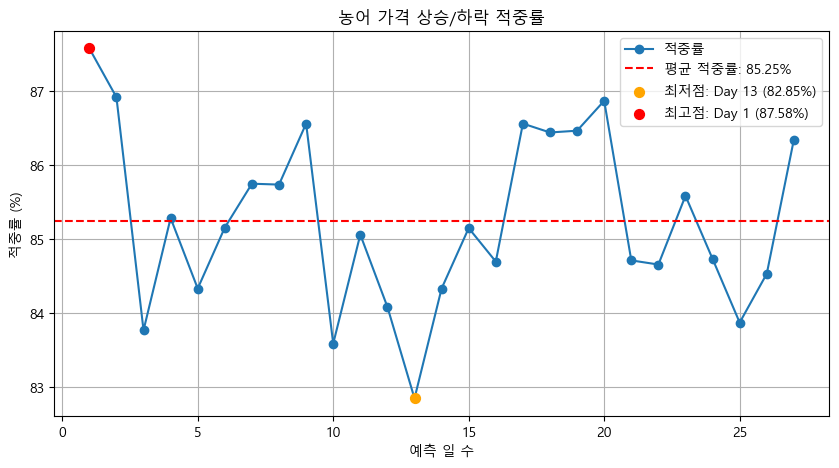


** 무조건 상승 예측 시 평균 적중률: 46.13% **
** 무조건 하락 예측 시 평균 적중률: 45.08% **
** 무조건 동결 예측 시 평균 적중률: 8.79% **

Feature Importances:
             Feature  Importance
10    avgPrice_lag_1  101.285714
21       농어_Gold_361   71.642857
22      농어_KOSPI_179   61.535714
25      농어_USD/KRW_1   55.821429
27        농어_WTI_100   35.464286
2         m_구리농수산물시장   33.142857
29    농어_수온_22107_81   32.785714
1         m_강서농수산물시장   30.928571
0             m_가락시장   30.571429
8       m_안양평촌농수산물시장   27.964286
3            m_노량진시장   26.750000
4         m_마포농수산물시장   26.571429
6        m_소래포구종합어시장   25.857143
9      m_인천종합연안부두어시장   23.964286
7         m_수원농수산물시장   23.500000
23         농어_MOVE_1   23.464286
26        농어_VIX_391   18.857143
24     농어_Silver_290   16.000000
28   농어_기온_22105_103    8.928571
11          농어_20대_1    7.428571
15          농어_40대_1    7.357143
13          농어_30대_1    3.535714
12        농어_20대_305    2.928571
14        농어_30대_307    2.357143
16        농어_40대_309    1.035714
30   농어_습도_22186_333 

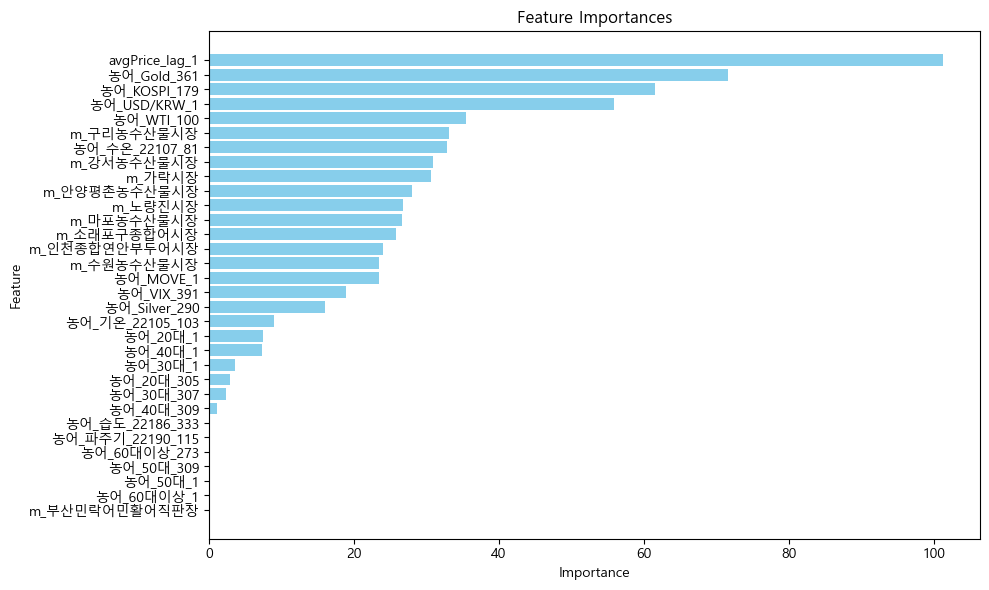

MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=0.9, max_depth=6,
                                             min_child_samples=6, n_jobs=-1,
                                             num_leaves=8, random_state=1030,
                                             subsample=0.9))

학습된 모델이 'lgbm_다중_농어.joblib'로 저장되었습니다.


In [167]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/농어_price_features_notnull.csv')
exclude_features = []
model_다중_농어 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_농어)

# 학습된 모델 저장
joblib.dump(model_다중_농어, 'lgbm_다중_농어.joblib')  

print("\n학습된 모델이 'lgbm_다중_농어.joblib'로 저장되었습니다.")

### 대게

In [168]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
	"""
	LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.

	Args:
		data (pd.DataFrame): 학습 데이터셋.
		target_col (str): 예측 대상 열 이름.
		exclude_features (list): 학습에 제외할 피처 리스트.
		steps (int): 예측할 시점 개수.
		time_series (bool): 타임 시리즈 데이터 여부.

	Returns:
		model: 학습된 멀티아웃풋 모델.
	"""
	# 날짜 열을 datetime 형식으로 변환
	data['date'] = pd.to_datetime(data['date'])

	# 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
	for step in range(1, steps + 1):
		data[f'{target_col}+{step}'] = data[target_col].shift(-step)
	data = data.dropna()  # NaN 값 제거

	# 입력 데이터와 다중 출력 타겟 설정
	X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
	y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]

	# 특정 피처 제외 (exclude_features 리스트 기반)
	if exclude_features:
		X = X.drop(columns=exclude_features)
    
    # LightGBM 하이퍼파라미터 설정
	lgbm_params = {
		'n_estimators': 90,
		'max_depth': 7,
		'learning_rate':0.1,
		'num_leaves': 8,
		'min_child_samples': 6,
		'subsample': 0.9,
		'colsample_bytree': 0.9,
		'random_state': 1030,
		'n_jobs': -1
	}
	# 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
	if time_series:
		test_size = len(X) // 10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		from sklearn.model_selection import ShuffleSplit
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	# MultiOutputRegressor로 멀티스텝 예측을 지원
	base_model = LGBMRegressor(**lgbm_params)
	multi_output_model = MultiOutputRegressor(base_model)

	# 모델 학습
	start_time = time.time()
	multi_output_model.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
	print("Feature names saved to 'feature_names_multi.pkl'")

	# 학습 시간 출력
	print(f"Training Time: {training_time:.2f} seconds")

	# 모델 예측
	y_pred = multi_output_model.predict(X)

	# 성능 평가 (RMSE, R2, MAE)
	rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
	r2 = r2_score(y, y_pred, multioutput='variance_weighted')
	mae = mean_absolute_error(y, y_pred, multioutput='raw_values')

	print("\n** Model Performance **")
	print(f"\nR2 Score: {r2:.4f}")
	print(f"\nRMSE (Per Step): {rmse}")
	print(f"\nMAE (Per Step): {mae}")

	avg_rmse = np.mean(rmse)
	max_rmse = np.max(rmse)
	min_rmse = np.min(rmse)
	avg_mae = np.mean(mae)

	print(f"\n평균 RMSE: {avg_rmse:.4f}")
	print(f"최대 RMSE: {max_rmse:.4f}")
	print(f"최소 RMSE: {min_rmse:.4f}")
	print(f'\n평균 MAE: {avg_mae:.4f}')
	print('-'*80)


	# 상승/하락 적중률 계산
	actual_trend = np.sign(y.diff(axis=1).fillna(0))
	predicted_trend = np.sign(y_pred[:, 1:] - y_pred[:, :-1])
	trend_accuracy = (actual_trend.iloc[:, 1:].values == predicted_trend).mean(axis=0) * 100

	avg_accuracy = np.mean(trend_accuracy)
	min_accuracy, max_accuracy = np.min(trend_accuracy), np.max(trend_accuracy)
	min_day, max_day = np.argmin(trend_accuracy) + 1, np.argmax(trend_accuracy) + 1

	print(f"\n평균 상승/하락 적중률: {avg_accuracy:.2f}%")
	print(f"최고 적중률: {max_accuracy:.2f}% (Day {max_day})")
	print(f"최저 적중률: {min_accuracy:.2f}% (Day {min_day})")

	print("일별 상승/하락 적중률:")
	for i, acc in enumerate(trend_accuracy, start=1):
		print(f"Day {i}: {acc:.2f}%")


	# 상승/하락 적중률 그래프
	plt.figure(figsize=(10, 5))
	plt.plot(range(1, steps ), trend_accuracy, marker='o', linestyle='-', label='적중률')
	plt.axhline(avg_accuracy, color='r', linestyle='--', label=f'평균 적중률: {avg_accuracy:.2f}%')
	plt.scatter(min_day , min_accuracy,  color='orange', s=50, label=f'최저점: Day {min_day} ({min_accuracy:.2f}%)', zorder= 3)
	plt.scatter(max_day , max_accuracy, color='red', s=50, label=f'최고점: Day {max_day} ({max_accuracy:.2f}%)', zorder= 3)
	plt.xlabel('예측 일 수')
	plt.ylabel('적중률 (%)')
	plt.title('대게게 가격 상승/하락 적중률')
	plt.legend()
	plt.grid()
	plt.show()


	# 실제 데이터 트렌드 변환
	actual_trend = classify_trend(np.diff(y, axis=1))  # DataFrame에서 numpy로 변환

	predicted_up = np.ones_like(actual_trend)	# **쭉 상승(1) 예측**
	predicted_down = -np.ones_like(actual_trend)	# **쭉 하락(-1) 예측**
	predicted_flat = np.zeros_like(actual_trend)	# **쭉 동결(0) 예측**

	# 적중률 계산
	accuracy_up = (actual_trend == predicted_up).mean(axis=0) * 100
	accuracy_down = (actual_trend == predicted_down).mean(axis=0) * 100
	accuracy_flat = (actual_trend == predicted_flat).mean(axis=0) * 100

	# 평균 적중률 계산
	avg_accuracy_up = np.mean(accuracy_up)
	avg_accuracy_down = np.mean(accuracy_down)
	avg_accuracy_flat = np.mean(accuracy_flat)

	# 결과 출력
	print(f"\n** 무조건 상승 예측 시 평균 적중률: {avg_accuracy_up:.2f}% **")
	print(f"** 무조건 하락 예측 시 평균 적중률: {avg_accuracy_down:.2f}% **")
	print(f"** 무조건 동결 예측 시 평균 적중률: {avg_accuracy_flat:.2f}% **")





	# 중요도 시각화
	feature_importances = np.mean([
		model.feature_importances_ for model in multi_output_model.estimators_
	], axis=0)
	importance_df = pd.DataFrame({
		'Feature': X.columns,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)

	print("\nFeature Importances:")
	print(importance_df)

	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
	plt.tight_layout()
	plt.show()



	return multi_output_model




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5113
[LightGBM] [Info] Number of data points in the train set: 21253, number of used features: 27
[LightGBM] [Info] Start training from score 56112.226039
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5113
[LightGBM] [Info] Number of data points in the train set: 21253, number of used features: 27
[LightGBM] [Info] Start training from score 56113.276714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5113
[LightGBM] [Info] Number of data points in the train set: 21253, number of used features: 27
[LightGBM] [Info] S

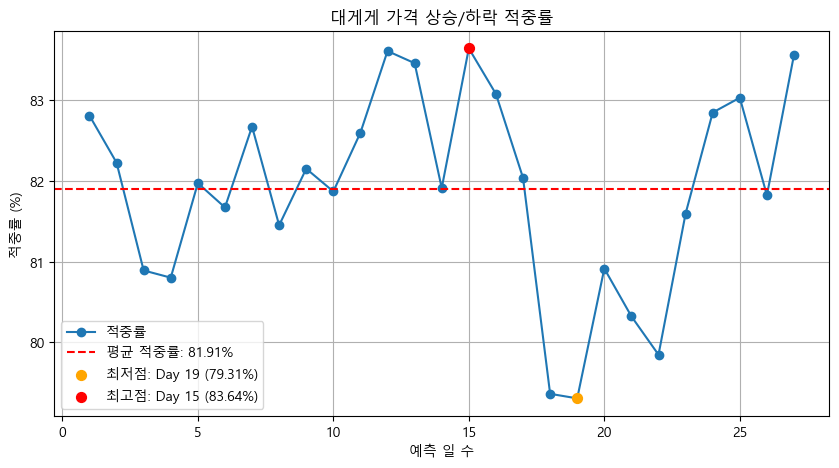


** 무조건 상승 예측 시 평균 적중률: 45.12% **
** 무조건 하락 예측 시 평균 적중률: 52.18% **
** 무조건 동결 예측 시 평균 적중률: 2.70% **

Feature Importances:
             Feature  Importance
9     avgPrice_lag_1   90.892857
20       대게_Gold_177   62.678571
22     대게_Silver_177   59.750000
24         대게_WTI_91   40.321429
21      대게_KOSPI_148   37.071429
2         m_구리농수산물시장   33.392857
0             m_가락시장   33.071429
5        m_소래포구종합어시장   30.464286
26   대게_수온_22188_140   29.750000
23     대게_USD/KRW_90   29.250000
1         m_강서농수산물시장   28.535714
6         m_수원농수산물시장   26.535714
7       m_안양평촌농수산물시장   23.464286
8      m_인천종합연안부두어시장   20.928571
25   대게_기온_22105_150   20.928571
11        대게_20대_273   18.892857
13        대게_30대_370    9.142857
19        대게_60대이상_5    5.464286
27   대게_습도_22188_355    5.392857
14          대게_40대_1    4.535714
10          대게_20대_1    4.071429
15          대게_40대_5    4.000000
17          대게_50대_5    3.821429
16          대게_50대_1    2.785714
12          대게_30대_1    2.535714
18        대게_60대이상_1 

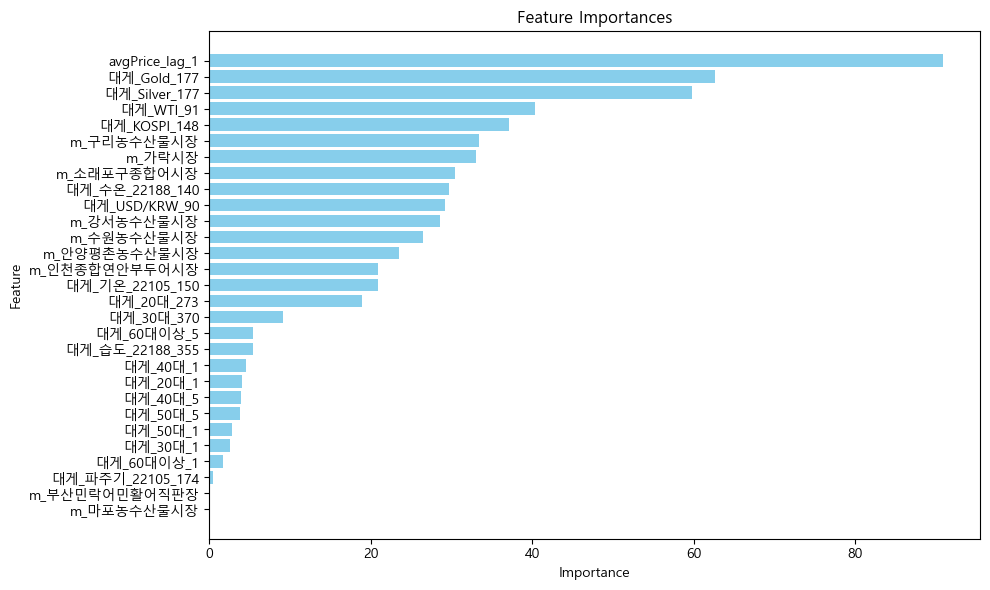

MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=0.9, max_depth=7,
                                             min_child_samples=6,
                                             n_estimators=90, n_jobs=-1,
                                             num_leaves=8, random_state=1030,
                                             subsample=0.9))

학습된 모델이 'lgbm_다중_대게.joblib'로 저장되었습니다.


In [169]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/대게_price_features_notnull.csv')
exclude_features = ['m_노량진시장']
model_다중_대게 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_대게)

# 학습된 모델 저장
joblib.dump(model_다중_대게, 'lgbm_다중_대게.joblib')  

print("\n학습된 모델이 'lgbm_다중_대게.joblib'로 저장되었습니다.")

### 방어

In [170]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
	"""
	LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.

	Args:
		data (pd.DataFrame): 학습 데이터셋.
		target_col (str): 예측 대상 열 이름.
		exclude_features (list): 학습에 제외할 피처 리스트.
		steps (int): 예측할 시점 개수.
		time_series (bool): 타임 시리즈 데이터 여부.

	Returns:
		model: 학습된 멀티아웃풋 모델.
	"""
	# 날짜 열을 datetime 형식으로 변환
	data['date'] = pd.to_datetime(data['date'])

	# 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
	for step in range(1, steps + 1):
		data[f'{target_col}+{step}'] = data[target_col].shift(-step)
	data = data.dropna()  # NaN 값 제거

	# 입력 데이터와 다중 출력 타겟 설정
	X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
	y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]

	# 특정 피처 제외 (exclude_features 리스트 기반)
	if exclude_features:
		X = X.drop(columns=exclude_features)
    
    # LightGBM 하이퍼파라미터 설정
	lgbm_params = {
		'n_estimators': 45,
		'max_depth': 2,
		'learning_rate': 0.11,
		'num_leaves': 4,
		'min_child_samples': 7,
		'subsample': 0.9,
		'colsample_bytree': 0.9,
		'random_state': 1030,
		'n_jobs': -1
	}

	# 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
	if time_series:
		test_size = len(X) // 10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		from sklearn.model_selection import ShuffleSplit
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	# MultiOutputRegressor로 멀티스텝 예측을 지원
	base_model = LGBMRegressor(**lgbm_params)
	multi_output_model = MultiOutputRegressor(base_model)

	# 모델 학습
	start_time = time.time()
	multi_output_model.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
	print("Feature names saved to 'feature_names_multi.pkl'")

	# 학습 시간 출력
	print(f"Training Time: {training_time:.2f} seconds")

	# 모델 예측
	y_pred = multi_output_model.predict(X)

	# 성능 평가 (RMSE, R2, MAE)
	rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
	r2 = r2_score(y, y_pred, multioutput='variance_weighted')
	mae = mean_absolute_error(y, y_pred, multioutput='raw_values')

	print("\n** Model Performance **")
	print(f"\nR2 Score: {r2:.4f}")
	print(f"\nRMSE (Per Step): {rmse}")
	print(f"\nMAE (Per Step): {mae}")

	avg_rmse = np.mean(rmse)
	max_rmse = np.max(rmse)
	min_rmse = np.min(rmse)
	avg_mae = np.mean(mae)

	print(f"\n평균 RMSE: {avg_rmse:.4f}")
	print(f"최대 RMSE: {max_rmse:.4f}")
	print(f"최소 RMSE: {min_rmse:.4f}")
	print(f'\n평균 MAE: {avg_mae:.4f}')
	print('-'*80)


	# 상승/하락 적중률 계산
	actual_trend = np.sign(y.diff(axis=1).fillna(0))
	predicted_trend = np.sign(y_pred[:, 1:] - y_pred[:, :-1])
	trend_accuracy = (actual_trend.iloc[:, 1:].values == predicted_trend).mean(axis=0) * 100

	avg_accuracy = np.mean(trend_accuracy)
	min_accuracy, max_accuracy = np.min(trend_accuracy), np.max(trend_accuracy)
	min_day, max_day = np.argmin(trend_accuracy) + 1, np.argmax(trend_accuracy) + 1

	print(f"\n평균 상승/하락 적중률: {avg_accuracy:.2f}%")
	print(f"최고 적중률: {max_accuracy:.2f}% (Day {max_day})")
	print(f"최저 적중률: {min_accuracy:.2f}% (Day {min_day})")

	print("일별 상승/하락 적중률:")
	for i, acc in enumerate(trend_accuracy, start=1):
		print(f"Day {i}: {acc:.2f}%")


	# 상승/하락 적중률 그래프
	plt.figure(figsize=(10, 5))
	plt.plot(range(1, steps ), trend_accuracy, marker='o', linestyle='-', label='적중률')
	plt.axhline(avg_accuracy, color='r', linestyle='--', label=f'평균 적중률: {avg_accuracy:.2f}%')
	plt.scatter(min_day , min_accuracy,  color='orange', s=50, label=f'최저점: Day {min_day} ({min_accuracy:.2f}%)', zorder= 3)
	plt.scatter(max_day , max_accuracy, color='red', s=50, label=f'최고점: Day {max_day} ({max_accuracy:.2f}%)', zorder= 3)
	plt.xlabel('예측 일 수')
	plt.ylabel('적중률 (%)')
	plt.title('방방어 가격 상승/하락 적중률')
	plt.legend()
	plt.grid()
	plt.show()


	# 실제 데이터 트렌드 변환
	actual_trend = classify_trend(np.diff(y, axis=1))  # DataFrame에서 numpy로 변환

	predicted_up = np.ones_like(actual_trend)	# **쭉 상승(1) 예측**
	predicted_down = -np.ones_like(actual_trend)	# **쭉 하락(-1) 예측**
	predicted_flat = np.zeros_like(actual_trend)	# **쭉 동결(0) 예측**

	# 적중률 계산
	accuracy_up = (actual_trend == predicted_up).mean(axis=0) * 100
	accuracy_down = (actual_trend == predicted_down).mean(axis=0) * 100
	accuracy_flat = (actual_trend == predicted_flat).mean(axis=0) * 100

	# 평균 적중률 계산
	avg_accuracy_up = np.mean(accuracy_up)
	avg_accuracy_down = np.mean(accuracy_down)
	avg_accuracy_flat = np.mean(accuracy_flat)

	# 결과 출력
	print(f"\n** 무조건 상승 예측 시 평균 적중률: {avg_accuracy_up:.2f}% **")
	print(f"** 무조건 하락 예측 시 평균 적중률: {avg_accuracy_down:.2f}% **")
	print(f"** 무조건 동결 예측 시 평균 적중률: {avg_accuracy_flat:.2f}% **")





	# 중요도 시각화
	feature_importances = np.mean([
		model.feature_importances_ for model in multi_output_model.estimators_
	], axis=0)
	importance_df = pd.DataFrame({
		'Feature': X.columns,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)

	print("\nFeature Importances:")
	print(importance_df)

	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
	plt.tight_layout()
	plt.show()



	return multi_output_model




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4687
[LightGBM] [Info] Number of data points in the train set: 9498, number of used features: 27
[LightGBM] [Info] Start training from score 36465.434828
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4687
[LightGBM] [Info] Number of data points in the train set: 9498, number of used features: 27
[LightGBM] [Info] Start training from score 36466.487682
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4687
[LightGBM] [Info] Number of data points in the train set: 9498, number of used features: 27
[LightGBM] [Info] Star

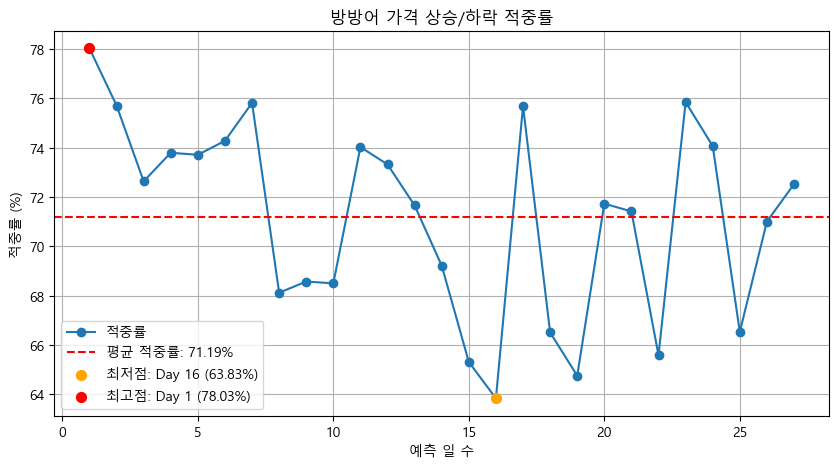


** 무조건 상승 예측 시 평균 적중률: 45.48% **
** 무조건 하락 예측 시 평균 적중률: 42.43% **
** 무조건 동결 예측 시 평균 적중률: 12.10% **

Feature Importances:
            Feature  Importance
10   avgPrice_lag_1   23.357143
19        방어_Gold_1   15.642857
25       방어_WTI_399   14.750000
9     m_인천종합연안부두어시장    9.928571
3           m_노량진시장    9.035714
6       m_소래포구종합어시장    7.857143
2        m_구리농수산물시장    7.464286
23   방어_USD/KRW_387    7.357143
0            m_가락시장    6.535714
20     방어_KOSPI_282    5.857143
1        m_강서농수산물시장    5.821429
7        m_수원농수산물시장    5.214286
21      방어_MOVE_381    4.071429
27  방어_수온_22107_118    2.964286
26  방어_기온_22190_114    2.500000
24       방어_VIX_133    2.392857
12        방어_20대_22    1.250000
22      방어_Silver_1    0.892857
14        방어_30대_26    0.607143
28  방어_습도_22190_158    0.392857
11         방어_20대_1    0.321429
5     m_부산민락어민활어직판장    0.285714
15         방어_40대_1    0.178571
13         방어_30대_1    0.142857
18      방어_60대이상_26    0.107143
17         방어_50대_1    0.035714
16       방어_40

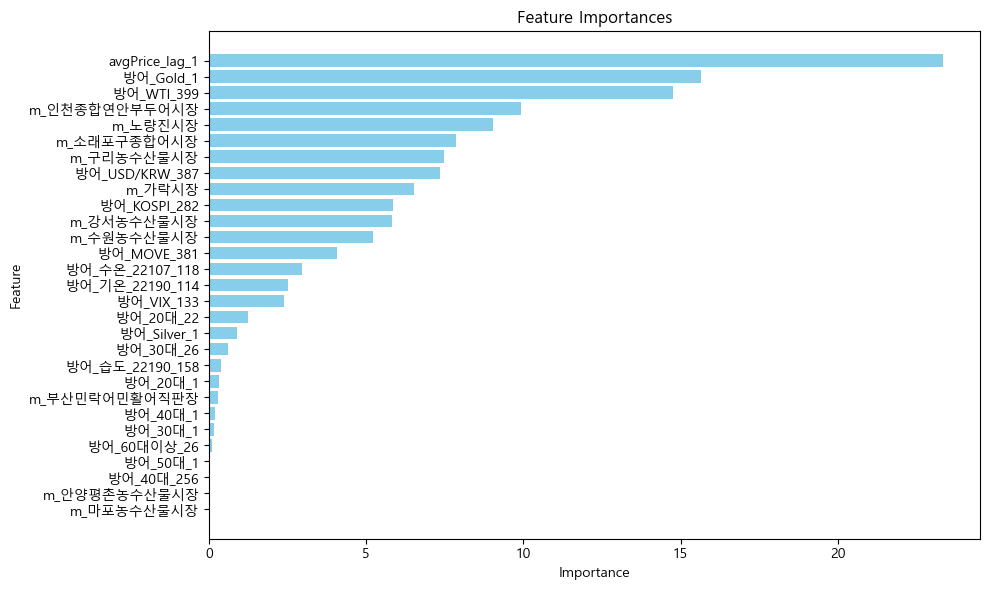

MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=0.9,
                                             learning_rate=0.11, max_depth=2,
                                             min_child_samples=7,
                                             n_estimators=45, n_jobs=-1,
                                             num_leaves=4, random_state=1030,
                                             subsample=0.9))

학습된 모델이 'lgbm_다중_방어.joblib'로 저장되었습니다.


In [171]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/방어_price_features_notnull.csv')
exclude_features = [
        '방어_60대이상_1',
        '방어_50대_256',
  '방어_파주기_22105_191'    
	
]
model_다중_방어 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_방어)

# 학습된 모델 저장
joblib.dump(model_다중_방어, 'lgbm_다중_방어.joblib')  

print("\n학습된 모델이 'lgbm_다중_방어.joblib'로 저장되었습니다.")

### 연어 노르웨이 제외 

In [172]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
	"""
	LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.

	Args:
		data (pd.DataFrame): 학습 데이터셋.
		target_col (str): 예측 대상 열 이름.
		exclude_features (list): 학습에 제외할 피처 리스트.
		steps (int): 예측할 시점 개수.
		time_series (bool): 타임 시리즈 데이터 여부.

	Returns:
		model: 학습된 멀티아웃풋 모델.
	"""
	# 날짜 열을 datetime 형식으로 변환
	data['date'] = pd.to_datetime(data['date'])

	# 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
	for step in range(1, steps + 1):
		data[f'{target_col}+{step}'] = data[target_col].shift(-step)
	data = data.dropna()  # NaN 값 제거

	# 입력 데이터와 다중 출력 타겟 설정
	X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
	y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]

	# 특정 피처 제외 (exclude_features 리스트 기반)
	if exclude_features:
		X = X.drop(columns=exclude_features)
    
    # LightGBM 하이퍼파라미터 설정
	lgbm_params = {
		'n_estimators': 60,
		'max_depth': 7,
		'learning_rate': 0.09,
		'num_leaves': 8,
		'min_child_samples': 6,
		'subsample': 0.9,
		'colsample_bytree': 0.9,
		'random_state': 1030,
		'n_jobs': -1
	}
	# 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
	if time_series:
		test_size = len(X) // 10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		from sklearn.model_selection import ShuffleSplit
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	# MultiOutputRegressor로 멀티스텝 예측을 지원
	base_model = LGBMRegressor(**lgbm_params)
	multi_output_model = MultiOutputRegressor(base_model)

	# 모델 학습
	start_time = time.time()
	multi_output_model.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
	print("Feature names saved to 'feature_names_multi.pkl'")

	# 학습 시간 출력
	print(f"Training Time: {training_time:.2f} seconds")

	# 모델 예측
	y_pred = multi_output_model.predict(X)

	# 성능 평가 (RMSE, R2, MAE)
	rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
	r2 = r2_score(y, y_pred, multioutput='variance_weighted')
	mae = mean_absolute_error(y, y_pred, multioutput='raw_values')

	print("\n** Model Performance **")
	print(f"\nR2 Score: {r2:.4f}")
	print(f"\nRMSE (Per Step): {rmse}")
	print(f"\nMAE (Per Step): {mae}")

	avg_rmse = np.mean(rmse)
	max_rmse = np.max(rmse)
	min_rmse = np.min(rmse)
	avg_mae = np.mean(mae)

	print(f"\n평균 RMSE: {avg_rmse:.4f}")
	print(f"최대 RMSE: {max_rmse:.4f}")
	print(f"최소 RMSE: {min_rmse:.4f}")
	print(f'\n평균 MAE: {avg_mae:.4f}')
	print('-'*80)


	# 상승/하락 적중률 계산
	actual_trend = np.sign(y.diff(axis=1).fillna(0))
	predicted_trend = np.sign(y_pred[:, 1:] - y_pred[:, :-1])
	trend_accuracy = (actual_trend.iloc[:, 1:].values == predicted_trend).mean(axis=0) * 100

	avg_accuracy = np.mean(trend_accuracy)
	min_accuracy, max_accuracy = np.min(trend_accuracy), np.max(trend_accuracy)
	min_day, max_day = np.argmin(trend_accuracy) + 1, np.argmax(trend_accuracy) + 1

	print(f"\n평균 상승/하락 적중률: {avg_accuracy:.2f}%")
	print(f"최고 적중률: {max_accuracy:.2f}% (Day {max_day})")
	print(f"최저 적중률: {min_accuracy:.2f}% (Day {min_day})")

	print("일별 상승/하락 적중률:")
	for i, acc in enumerate(trend_accuracy, start=1):
		print(f"Day {i}: {acc:.2f}%")


	# 상승/하락 적중률 그래프
	plt.figure(figsize=(10, 5))
	plt.plot(range(1, steps ), trend_accuracy, marker='o', linestyle='-', label='적중률')
	plt.axhline(avg_accuracy, color='r', linestyle='--', label=f'평균 적중률: {avg_accuracy:.2f}%')
	plt.scatter(min_day , min_accuracy,  color='orange', s=50, label=f'최저점: Day {min_day} ({min_accuracy:.2f}%)', zorder= 3)
	plt.scatter(max_day , max_accuracy, color='red', s=50, label=f'최고점: Day {max_day} ({max_accuracy:.2f}%)', zorder= 3)
	plt.xlabel('예측 일 수')
	plt.ylabel('적중률 (%)')
	plt.title('연어 가격 상승/하락 적중률')
	plt.legend()
	plt.grid()
	plt.show()


	# 실제 데이터 트렌드 변환
	actual_trend = classify_trend(np.diff(y, axis=1))  # DataFrame에서 numpy로 변환

	predicted_up = np.ones_like(actual_trend)	# **쭉 상승(1) 예측**
	predicted_down = -np.ones_like(actual_trend)	# **쭉 하락(-1) 예측**
	predicted_flat = np.zeros_like(actual_trend)	# **쭉 동결(0) 예측**

	# 적중률 계산
	accuracy_up = (actual_trend == predicted_up).mean(axis=0) * 100
	accuracy_down = (actual_trend == predicted_down).mean(axis=0) * 100
	accuracy_flat = (actual_trend == predicted_flat).mean(axis=0) * 100

	# 평균 적중률 계산
	avg_accuracy_up = np.mean(accuracy_up)
	avg_accuracy_down = np.mean(accuracy_down)
	avg_accuracy_flat = np.mean(accuracy_flat)

	# 결과 출력
	print(f"\n** 무조건 상승 예측 시 평균 적중률: {avg_accuracy_up:.2f}% **")
	print(f"** 무조건 하락 예측 시 평균 적중률: {avg_accuracy_down:.2f}% **")
	print(f"** 무조건 동결 예측 시 평균 적중률: {avg_accuracy_flat:.2f}% **")






	# 중요도 시각화
	feature_importances = np.mean([
		model.feature_importances_ for model in multi_output_model.estimators_
	], axis=0)
	importance_df = pd.DataFrame({
		'Feature': X.columns,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)

	print("\nFeature Importances:")
	print(importance_df)

	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
	plt.tight_layout()
	plt.show()



	return multi_output_model




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3254
[LightGBM] [Info] Number of data points in the train set: 23713, number of used features: 22
[LightGBM] [Info] Start training from score 4766.935015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3254
[LightGBM] [Info] Number of data points in the train set: 23713, number of used features: 22
[LightGBM] [Info] Start training from score 4767.119723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3254
[LightGBM] [Info] Number of data points in the train set: 23713, number of used features: 22
[LightGBM] [Info] Sta

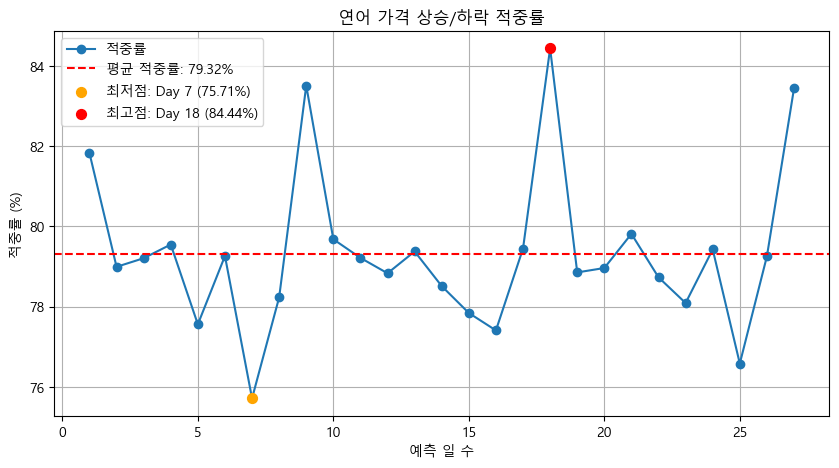


** 무조건 상승 예측 시 평균 적중률: 52.73% **
** 무조건 하락 예측 시 평균 적중률: 40.47% **
** 무조건 동결 예측 시 평균 적중률: 6.80% **

Feature Importances:
            Feature  Importance
13        연어_Gold_1   89.750000
10   avgPrice_lag_1   63.500000
17     연어_USD/KRW_1   33.500000
14     연어_KOSPI_329   25.428571
1        m_강서농수산물시장   21.392857
2        m_구리농수산물시장   20.178571
3           m_노량진시장   19.607143
6       m_소래포구종합어시장   19.428571
4        m_마포농수산물시장   18.928571
9     m_인천종합연안부두어시장   17.607143
7        m_수원농수산물시장   16.750000
8      m_안양평촌농수산물시장   16.714286
19       연어_WTI_199   15.928571
0            m_가락시장   14.535714
15       연어_MOVE_71    8.714286
16    연어_Silver_399    6.142857
21  연어_수온_22107_341    5.642857
18       연어_VIX_399    2.964286
12        연어_20대_20    1.357143
11         연어_20대_1    1.000000
20  연어_기온_22105_394    0.642857
22    연어_습도_22105_8    0.285714
5     m_부산민락어민활어직판장    0.000000


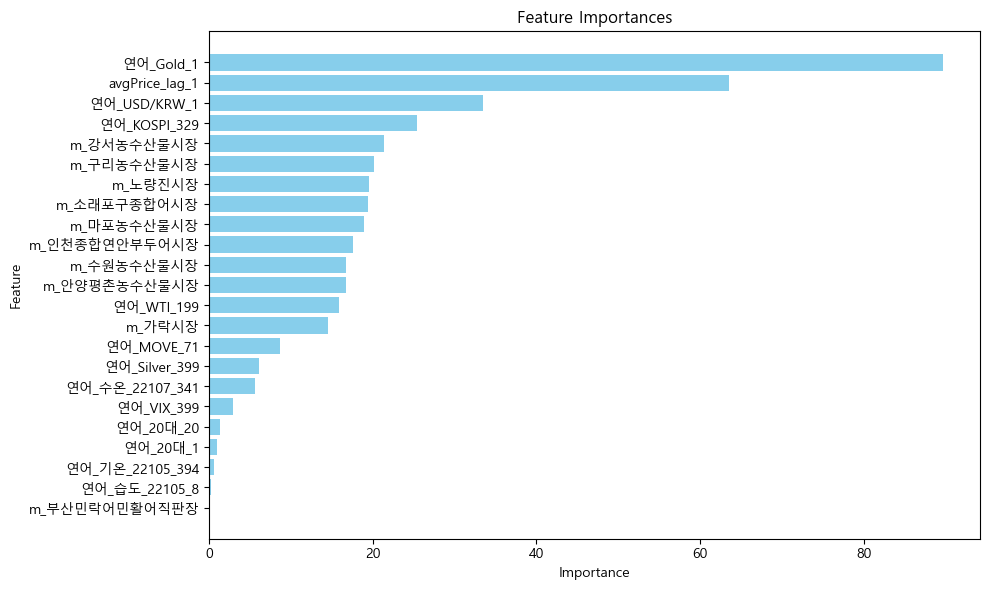

MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=0.9,
                                             learning_rate=0.09, max_depth=7,
                                             min_child_samples=6,
                                             n_estimators=60, n_jobs=-1,
                                             num_leaves=8, random_state=1030,
                                             subsample=0.9))

학습된 모델이 'lgbm_다중_연어.joblib'로 저장되었습니다.


In [173]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/연어_price_features_notnull_노르웨이제외.csv')
exclude_features = [
        '연어_40대_21',
     '연어_60대이상_397',
        '연어_50대_15',
   '연어_파주기_22190_9',

       '연어_60대이상_1',
         '연어_50대_1',
         '연어_40대_1',
         '연어_30대_1',
        '연어_30대_15'


]
model_다중_연어 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_연어)

# 학습된 모델 저장
joblib.dump(model_다중_연어, 'lgbm_다중_연어.joblib')  

print("\n학습된 모델이 'lgbm_다중_연어.joblib'로 저장되었습니다.")

### 우럭

In [174]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
	"""
	LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.

	Args:
		data (pd.DataFrame): 학습 데이터셋.
		target_col (str): 예측 대상 열 이름.
		exclude_features (list): 학습에 제외할 피처 리스트.
		steps (int): 예측할 시점 개수.
		time_series (bool): 타임 시리즈 데이터 여부.

	Returns:
		model: 학습된 멀티아웃풋 모델.
	"""
	# 날짜 열을 datetime 형식으로 변환
	data['date'] = pd.to_datetime(data['date'])

	# 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
	for step in range(1, steps + 1):
		data[f'{target_col}+{step}'] = data[target_col].shift(-step)
	data = data.dropna()  # NaN 값 제거

	# 입력 데이터와 다중 출력 타겟 설정
	X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
	y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]

	# 특정 피처 제외 (exclude_features 리스트 기반)
	if exclude_features:
		X = X.drop(columns=exclude_features)
    
    # LightGBM 하이퍼파라미터 설정
	lgbm_params = {
        'n_estimators': 105,
        'max_depth': 3,
        'learning_rate': 0.1,
        'num_leaves': 4,
        'min_child_samples': 8,
        'subsample': 0.9,
        'colsample_bytree': 0.9,
        'random_state': 1030,
        'n_jobs': -1
	}

	# 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
	if time_series:
		test_size = len(X) // 10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		from sklearn.model_selection import ShuffleSplit
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	# MultiOutputRegressor로 멀티스텝 예측을 지원
	base_model = LGBMRegressor(**lgbm_params)
	multi_output_model = MultiOutputRegressor(base_model)

	# 모델 학습
	start_time = time.time()
	multi_output_model.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
	print("Feature names saved to 'feature_names_multi.pkl'")

	# 학습 시간 출력
	print(f"Training Time: {training_time:.2f} seconds")

	# 모델 예측
	y_pred = multi_output_model.predict(X)

	# 성능 평가 (RMSE, R2, MAE)
	rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
	r2 = r2_score(y, y_pred, multioutput='variance_weighted')
	mae = mean_absolute_error(y, y_pred, multioutput='raw_values')

	print("\n** Model Performance **")
	print(f"\nR2 Score: {r2:.4f}")
	print(f"\nRMSE (Per Step): {rmse}")
	print(f"\nMAE (Per Step): {mae}")

	avg_rmse = np.mean(rmse)
	max_rmse = np.max(rmse)
	min_rmse = np.min(rmse)
	avg_mae = np.mean(mae)

	print(f"\n평균 RMSE: {avg_rmse:.4f}")
	print(f"최대 RMSE: {max_rmse:.4f}")
	print(f"최소 RMSE: {min_rmse:.4f}")
	print(f'\n평균 MAE: {avg_mae:.4f}')
	print('-'*80)


	# 상승/하락 적중률 계산
	actual_trend = np.sign(y.diff(axis=1).fillna(0))
	predicted_trend = np.sign(y_pred[:, 1:] - y_pred[:, :-1])
	trend_accuracy = (actual_trend.iloc[:, 1:].values == predicted_trend).mean(axis=0) * 100

	avg_accuracy = np.mean(trend_accuracy)
	min_accuracy, max_accuracy = np.min(trend_accuracy), np.max(trend_accuracy)
	min_day, max_day = np.argmin(trend_accuracy) + 1, np.argmax(trend_accuracy) + 1

	print(f"\n평균 상승/하락 적중률: {avg_accuracy:.2f}%")
	print(f"최고 적중률: {max_accuracy:.2f}% (Day {max_day})")
	print(f"최저 적중률: {min_accuracy:.2f}% (Day {min_day})")

	print("일별 상승/하락 적중률:")
	for i, acc in enumerate(trend_accuracy, start=1):
		print(f"Day {i}: {acc:.2f}%")


	# 상승/하락 적중률 그래프
	plt.figure(figsize=(10, 5))
	plt.plot(range(1, steps ), trend_accuracy, marker='o', linestyle='-', label='적중률')
	plt.axhline(avg_accuracy, color='r', linestyle='--', label=f'평균 적중률: {avg_accuracy:.2f}%')
	plt.scatter(min_day , min_accuracy,  color='orange', s=50, label=f'최저점: Day {min_day} ({min_accuracy:.2f}%)', zorder= 3)
	plt.scatter(max_day , max_accuracy, color='red', s=50, label=f'최고점: Day {max_day} ({max_accuracy:.2f}%)', zorder= 3)
	plt.xlabel('예측 일 수')
	plt.ylabel('적중률 (%)')
	plt.title('우럭 가격 상승/하락 적중률')
	plt.legend()
	plt.grid()
	plt.show()


	# 실제 데이터 트렌드 변환
	actual_trend = classify_trend(np.diff(y, axis=1))  # DataFrame에서 numpy로 변환

	predicted_up = np.ones_like(actual_trend)	# **쭉 상승(1) 예측**
	predicted_down = -np.ones_like(actual_trend)	# **쭉 하락(-1) 예측**
	predicted_flat = np.zeros_like(actual_trend)	# **쭉 동결(0) 예측**

	# 적중률 계산
	accuracy_up = (actual_trend == predicted_up).mean(axis=0) * 100
	accuracy_down = (actual_trend == predicted_down).mean(axis=0) * 100
	accuracy_flat = (actual_trend == predicted_flat).mean(axis=0) * 100

	# 평균 적중률 계산
	avg_accuracy_up = np.mean(accuracy_up)
	avg_accuracy_down = np.mean(accuracy_down)
	avg_accuracy_flat = np.mean(accuracy_flat)

	# 결과 출력
	print(f"\n** 무조건 상승 예측 시 평균 적중률: {avg_accuracy_up:.2f}% **")
	print(f"** 무조건 하락 예측 시 평균 적중률: {avg_accuracy_down:.2f}% **")
	print(f"** 무조건 동결 예측 시 평균 적중률: {avg_accuracy_flat:.2f}% **")





	# 중요도 시각화
	feature_importances = np.mean([
		model.feature_importances_ for model in multi_output_model.estimators_
	], axis=0)
	importance_df = pd.DataFrame({
		'Feature': X.columns,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)

	print("\nFeature Importances:")
	print(importance_df)

	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
	plt.tight_layout()
	plt.show()



	return multi_output_model




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5131
[LightGBM] [Info] Number of data points in the train set: 5297, number of used features: 31
[LightGBM] [Info] Start training from score 33540.475741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5131
[LightGBM] [Info] Number of data points in the train set: 5297, number of used features: 31
[LightGBM] [Info] Start training from score 33541.419672
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5131
[LightGBM] [Info] Number of data points in the train set: 5297, number of used features: 31
[LightGBM] [Info] Star

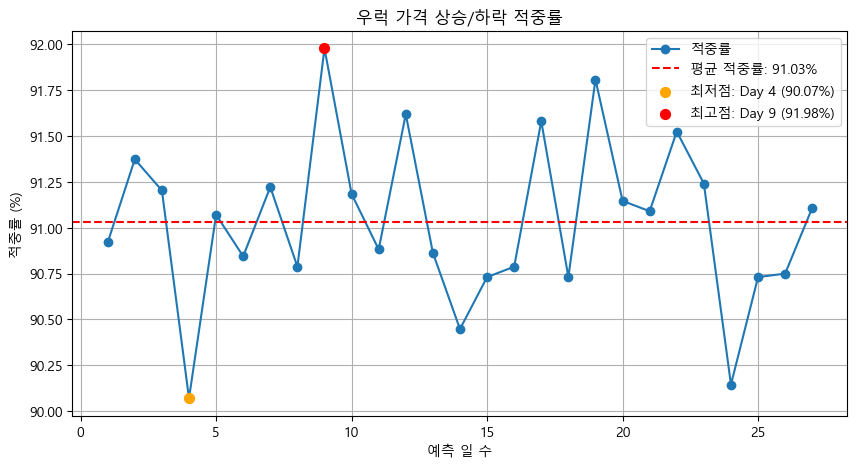


** 무조건 상승 예측 시 평균 적중률: 43.15% **
** 무조건 하락 예측 시 평균 적중률: 50.29% **
** 무조건 동결 예측 시 평균 적중률: 6.56% **

Feature Importances:
             Feature  Importance
10    avgPrice_lag_1   39.785714
7         m_수원농수산물시장   21.785714
22      우럭_KOSPI_155   21.178571
3            m_노량진시장   20.928571
5      m_부산민락어민활어직판장   19.678571
4         m_마포농수산물시장   19.357143
8       m_안양평촌농수산물시장   19.107143
2         m_구리농수산물시장   18.892857
9      m_인천종합연안부두어시장   16.607143
0             m_가락시장   16.535714
6        m_소래포구종합어시장   14.750000
21       우럭_Gold_146   13.714286
23     우럭_Silver_125   12.928571
1         m_강서농수산물시장   12.535714
27   우럭_기온_22186_118   11.500000
28   우럭_수온_22186_113   10.071429
26         우럭_WTI_14    7.357143
24    우럭_USD/KRW_121    4.892857
30  우럭_파주기_22189_172    3.107143
12         우럭_20대_22    2.214286
11          우럭_20대_1    2.214286
19        우럭_60대이상_1    1.035714
13          우럭_30대_1    0.892857
20      우럭_60대이상_219    0.750000
15          우럭_40대_1    0.714286
16        우럭_40대_354 

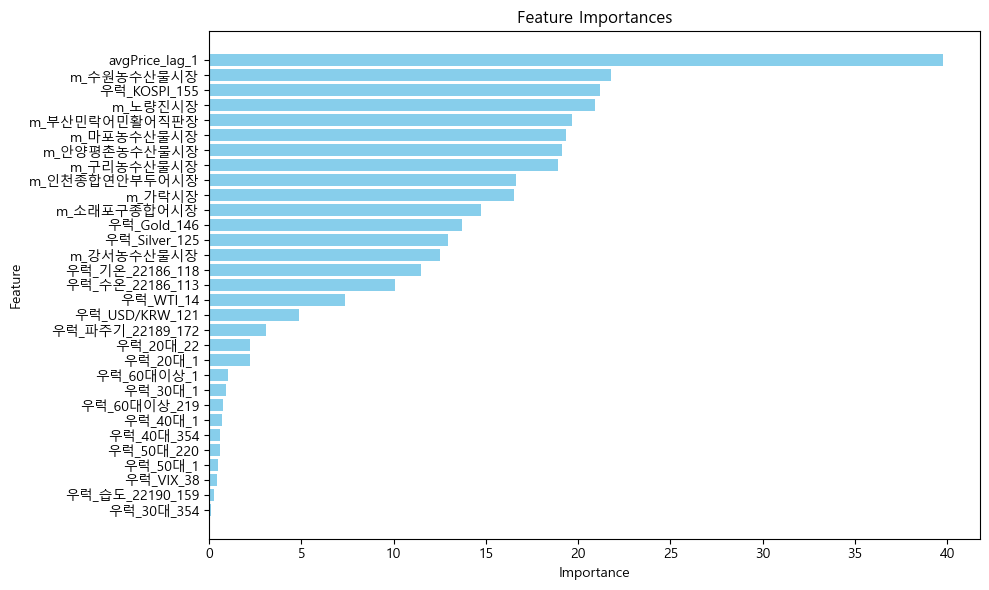

MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=0.9, max_depth=3,
                                             min_child_samples=8,
                                             n_estimators=105, n_jobs=-1,
                                             num_leaves=4, random_state=1030,
                                             subsample=0.9))

학습된 모델이 'lgbm_다중_우럭.joblib'로 저장되었습니다.


In [175]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/우럭_price_features_notnull.csv')
exclude_features = []
model_다중_우럭 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_우럭)

# 학습된 모델 저장
joblib.dump(model_다중_우럭, 'lgbm_다중_우럭.joblib')  

print("\n학습된 모델이 'lgbm_다중_우럭.joblib'로 저장되었습니다.")

### 참돔


In [176]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
	"""
	LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.

	Args:
		data (pd.DataFrame): 학습 데이터셋.
		target_col (str): 예측 대상 열 이름.
		exclude_features (list): 학습에 제외할 피처 리스트.
		steps (int): 예측할 시점 개수.
		time_series (bool): 타임 시리즈 데이터 여부.

	Returns:
		model: 학습된 멀티아웃풋 모델.
	"""
	# 날짜 열을 datetime 형식으로 변환
	data['date'] = pd.to_datetime(data['date'])

	# 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
	for step in range(1, steps + 1):
		data[f'{target_col}+{step}'] = data[target_col].shift(-step)
	data = data.dropna()  # NaN 값 제거

	# 입력 데이터와 다중 출력 타겟 설정
	X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
	y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]

	# 특정 피처 제외 (exclude_features 리스트 기반)
	if exclude_features:
		X = X.drop(columns=exclude_features)
    
    # LightGBM 하이퍼파라미터 설정
	lgbm_params = {
		'n_estimators': 90,
		'max_depth': 7,
		'learning_rate': 0.1,
		'num_leaves': 8,
		'min_child_samples': 6,
		'subsample': 0.9,
		'colsample_bytree': 0.9,
		'random_state': 1030,
		'n_jobs': -1
	}

	# 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
	if time_series:
		test_size = len(X) // 10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		from sklearn.model_selection import ShuffleSplit
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	# MultiOutputRegressor로 멀티스텝 예측을 지원
	base_model = LGBMRegressor(**lgbm_params)
	multi_output_model = MultiOutputRegressor(base_model)

	# 모델 학습
	start_time = time.time()
	multi_output_model.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
	print("Feature names saved to 'feature_names_multi.pkl'")

	# 학습 시간 출력
	print(f"Training Time: {training_time:.2f} seconds")

	# 모델 예측
	y_pred = multi_output_model.predict(X)

	# 성능 평가 (RMSE, R2, MAE)
	rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
	r2 = r2_score(y, y_pred, multioutput='variance_weighted')
	mae = mean_absolute_error(y, y_pred, multioutput='raw_values')

	print("\n** Model Performance **")
	print(f"\nR2 Score: {r2:.4f}")
	print(f"\nRMSE (Per Step): {rmse}")
	print(f"\nMAE (Per Step): {mae}")

	avg_rmse = np.mean(rmse)
	max_rmse = np.max(rmse)
	min_rmse = np.min(rmse)
	avg_mae = np.mean(mae)

	print(f"\n평균 RMSE: {avg_rmse:.4f}")
	print(f"최대 RMSE: {max_rmse:.4f}")
	print(f"최소 RMSE: {min_rmse:.4f}")
	print(f'\n평균 MAE: {avg_mae:.4f}')
	print('-'*80)


	# 상승/하락 적중률 계산
	actual_trend = np.sign(y.diff(axis=1).fillna(0))
	predicted_trend = np.sign(y_pred[:, 1:] - y_pred[:, :-1])
	trend_accuracy = (actual_trend.iloc[:, 1:].values == predicted_trend).mean(axis=0) * 100

	avg_accuracy = np.mean(trend_accuracy)
	min_accuracy, max_accuracy = np.min(trend_accuracy), np.max(trend_accuracy)
	min_day, max_day = np.argmin(trend_accuracy) + 1, np.argmax(trend_accuracy) + 1

	print(f"\n평균 상승/하락 적중률: {avg_accuracy:.2f}%")
	print(f"최고 적중률: {max_accuracy:.2f}% (Day {max_day})")
	print(f"최저 적중률: {min_accuracy:.2f}% (Day {min_day})")

	print("일별 상승/하락 적중률:")
	for i, acc in enumerate(trend_accuracy, start=1):
		print(f"Day {i}: {acc:.2f}%")


	# 상승/하락 적중률 그래프
	plt.figure(figsize=(10, 5))
	plt.plot(range(1, steps ), trend_accuracy, marker='o', linestyle='-', label='적중률')
	plt.axhline(avg_accuracy, color='r', linestyle='--', label=f'평균 적중률: {avg_accuracy:.2f}%')
	plt.scatter(min_day , min_accuracy,  color='orange', s=50, label=f'최저점: Day {min_day} ({min_accuracy:.2f}%)', zorder= 3)
	plt.scatter(max_day , max_accuracy, color='red', s=50, label=f'최고점: Day {max_day} ({max_accuracy:.2f}%)', zorder= 3)
	plt.xlabel('예측 일 수')
	plt.ylabel('적중률 (%)')
	plt.title('참돔 가격 상승/하락 적중률')
	plt.legend()
	plt.grid()
	plt.show()


	# 실제 데이터 트렌드 변환
	actual_trend = classify_trend(np.diff(y, axis=1))  # DataFrame에서 numpy로 변환

	predicted_up = np.ones_like(actual_trend)	# **쭉 상승(1) 예측**
	predicted_down = -np.ones_like(actual_trend)	# **쭉 하락(-1) 예측**
	predicted_flat = np.zeros_like(actual_trend)	# **쭉 동결(0) 예측**

	# 적중률 계산
	accuracy_up = (actual_trend == predicted_up).mean(axis=0) * 100
	accuracy_down = (actual_trend == predicted_down).mean(axis=0) * 100
	accuracy_flat = (actual_trend == predicted_flat).mean(axis=0) * 100

	# 평균 적중률 계산
	avg_accuracy_up = np.mean(accuracy_up)
	avg_accuracy_down = np.mean(accuracy_down)
	avg_accuracy_flat = np.mean(accuracy_flat)

	# 결과 출력
	print(f"\n** 무조건 상승 예측 시 평균 적중률: {avg_accuracy_up:.2f}% **")
	print(f"** 무조건 하락 예측 시 평균 적중률: {avg_accuracy_down:.2f}% **")
	print(f"** 무조건 동결 예측 시 평균 적중률: {avg_accuracy_flat:.2f}% **")





	# 중요도 시각화
	feature_importances = np.mean([
		model.feature_importances_ for model in multi_output_model.estimators_
	], axis=0)
	importance_df = pd.DataFrame({
		'Feature': X.columns,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)

	print("\nFeature Importances:")
	print(importance_df)

	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
	plt.tight_layout()
	plt.show()



	return multi_output_model




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4755
[LightGBM] [Info] Number of data points in the train set: 23060, number of used features: 28
[LightGBM] [Info] Start training from score 37015.954900
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4755
[LightGBM] [Info] Number of data points in the train set: 23060, number of used features: 28
[LightGBM] [Info] Start training from score 37016.301821
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4755
[LightGBM] [Info] Number of data points in the train set: 23060, number of used features: 28
[LightGBM] [Info] S

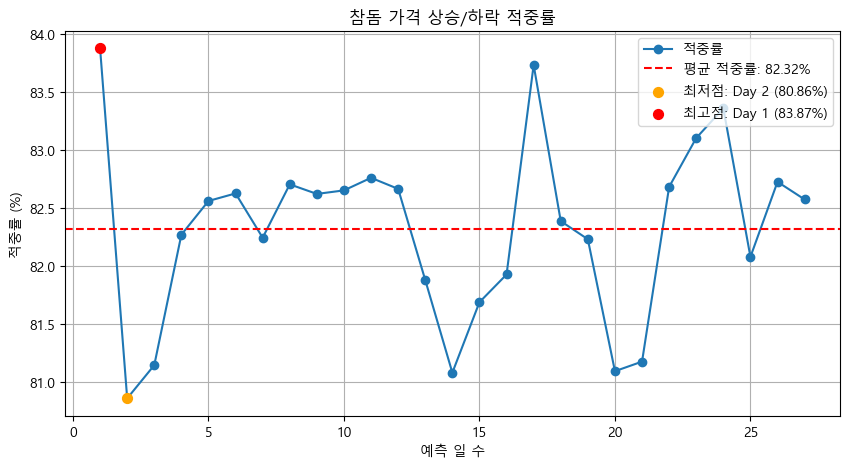


** 무조건 상승 예측 시 평균 적중률: 41.34% **
** 무조건 하락 예측 시 평균 적중률: 46.08% **
** 무조건 동결 예측 시 평균 적중률: 12.59% **

Feature Importances:
             Feature  Importance
10    avgPrice_lag_1   89.678571
23     참돔_USD/KRW_11   83.071429
24        참돔_WTI_150   73.035714
21      참돔_KOSPI_399   63.142857
22       참돔_MOVE_201   43.642857
0             m_가락시장   29.178571
6        m_소래포구종합어시장   28.857143
26    참돔_수온_22107_72   26.750000
2         m_구리농수산물시장   25.321429
9      m_인천종합연안부두어시장   24.857143
4         m_마포농수산물시장   24.750000
8       m_안양평촌농수산물시장   24.178571
7         m_수원농수산물시장   21.178571
1         m_강서농수산물시장   20.714286
3            m_노량진시장   19.250000
25    참돔_기온_22190_91   16.107143
27   참돔_습도_22190_115    3.035714
12        참돔_20대_197    2.928571
16        참돔_40대_278    2.607143
11          참돔_20대_1    2.428571
13          참돔_30대_1    1.785714
15          참돔_40대_1    1.607143
14        참돔_30대_167    0.857143
18        참돔_50대_193    0.285714
19        참돔_60대이상_1    0.214286
17          참돔_50대_1

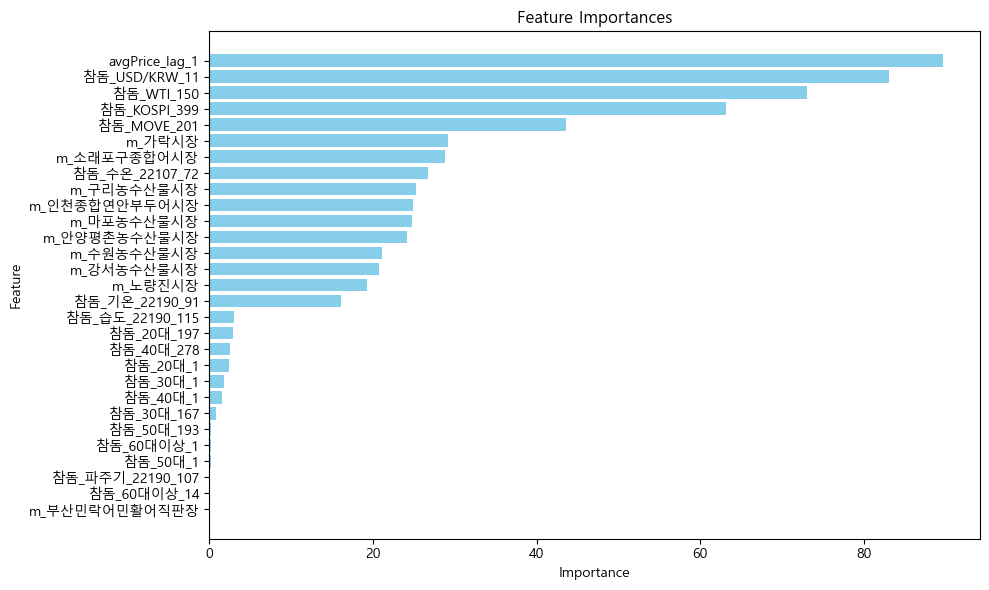

MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=0.9, max_depth=7,
                                             min_child_samples=6,
                                             n_estimators=90, n_jobs=-1,
                                             num_leaves=8, random_state=1030,
                                             subsample=0.9))

학습된 모델이 'lgbm_다중_참돔.joblib'로 저장되었습니다.


In [177]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/참돔_price_features_notnull.csv')
exclude_features = []
model_다중_참돔 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_참돔)

# 학습된 모델 저장
joblib.dump(model_다중_참돔, 'lgbm_다중_참돔.joblib')  

print("\n학습된 모델이 'lgbm_다중_참돔.joblib'로 저장되었습니다.")

### 가격 예측 

In [ ]:
# 저장된 모델 로드
loaded_model = joblib.load('lgbm_다중_광어.joblib')
print("모델이 성공적으로 로드되었습니다.")